<a href="https://colab.research.google.com/github/Gab2697/Surface-classification-EMG/blob/main/IMU_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import
import pandas as pd
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import os
from keras import layers 
from keras import models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers

from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop


from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Functions

Functions pre-process

In [ ]:
#================================Function to load data from excel================================
#organize it by surface and add a specifique label depending on the name of the excel file
def load_data(path,keyword,col):
    Window=240*2 #4 sec window
    df_asphalt = pd.DataFrame()
    df_grass = pd.DataFrame()
    for fname in os.listdir(path):
      if keyword in fname:
        os.chdir(path)
        Participant=pd.read_excel(fname,sheet_name='Sensor Free Acceleration',  usecols = col)
        dimensions = Participant.shape
        Middle=int(dimensions[0]/2)
        Participant['label'] = pd.DataFrame(np.ones(dimensions[0]),dtype=int)
        Participant=Participant.iloc[Middle-Window:Middle+Window]
        # df_asphalt = pd.concat([df_asphalt,Participant],axis=0)
        df_asphalt = df_asphalt.append(Participant)

      else:
        os.chdir(path)
        Participant_grass=pd.read_excel(fname,sheet_name='Sensor Free Acceleration', usecols = col)
        dimensions_grass = Participant_grass.shape
        Middle_grass=int(dimensions_grass[0]/2)
        Participant_grass['label'] = pd.DataFrame(np.zeros(dimensions_grass[0]),dtype=int)
        Participant_grass=Participant_grass.iloc[Middle_grass-Window:Middle_grass+Window]
        # df_grass = pd.concat([df_grass,Participant_grass],axis=0)
        df_grass = df_grass.append(Participant_grass)
        
    return df_asphalt, df_grass

#================================Save pickle file================================
def save_pickle(path_pickle,T):
    f = open(path_pickle, 'wb')
    pickle.dump(T, f)
    f.close()

    return f 

#================================Open pickle file================================
def open_pickle(path_pickle):
    f = open(path_pickle, 'rb')
    T = pickle.load(f)
    f.close()

    return T

#================================standardization================================    
def feature_standard(P0X): 
    P0X_stand_all=pd.DataFrame()
    for i in range(1, 52):
      mu = np.mean(P0X.iloc[:,i],axis = 0)
      sigma = np.std(P0X.iloc[:,i],axis = 0)
      P0X_stand=(P0X.iloc[:,i] - mu)/sigma
      P0X_stand_all=pd.concat([P0X_stand_all, P0X_stand],axis=1)
    P0X_stand_all=pd.concat([P0X_stand_all, P0X.iloc[:,52]],axis=1)#add label
    return P0X_stand_all 

#================================Creating tensor with specific shape================================
def create_tensor(df_a,df_g):
    #tensor asphalt 
    trials_a=len(df_a)/(240*4) # how many trials-80
    T_asphalt=np.stack(np.split(df_a.values, trials_a), axis=1)
    #tensor grass
    trials_g=len(df_g)/(240*4) # how many trials
    T_grass=np.stack(np.split(df_g.values, trials_g), axis=1)
    #tensor both conditions
    a=tf.constant(T_asphalt.astype('float32'))
    g=tf.constant(T_grass.astype('float32'))
    T = tf.concat([a, g], axis=1)

    return T
#================================ALL PREPROCESS================================
def all_pre_process_steps(path):
  #load data
  df_asphalt, df_grass= load_data(path,'asphalt','A,B,C,D,N,O,P,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ,BA,BB,BC,BG,BH,BI,BJ,BK,BL,BM,BN,BO')
  #plot
  plt.plot(range(0,len(df_asphalt.iloc[0:240*4,1])),df_asphalt.iloc[0:240*4,1])
  #stand
  P_asphalt_stand=feature_standard(df_asphalt)
  P_grass_stand=feature_standard(df_grass)  
  #tensor
  T_acc=create_tensor(P_asphalt_stand,P_grass_stand)
  print("T shape:", T_acc.shape)
  return T_acc


Functions CNN

In [ ]:
#================================shuffle================================
def tf_shuffle_axis(value, axis=0, seed=None, name=None):
    perm = list(range(tf.rank(value)))
    perm[axis], perm[0] = perm[0], perm[axis]
    value = tf.random.shuffle(tf.transpose(value, perm=perm))
    value = tf.transpose(value, perm=perm)
    return value

#================================CNN================================

def make_model_1D(input_size,filter_numb1,filter_numb2,filter_numb3,kernel_size,pool_size,opt):
    #Instantiating convnet
    model = models.Sequential()
    #filter size: 32, kenel of 3, input shape without the batch_size (one trial), padding= with zero padding
    model.add(layers.Conv1D(filter_numb1, kernel_size,activation='relu',kernel_regularizer=regularizers.l2(0.001), input_shape=(input_size),padding='same')) 
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size))
    model.add(layers.Conv1D(filter_numb2, kernel_size,activation='relu',kernel_regularizer=regularizers.l2(0.001),padding='same'))

    model.add(layers.Conv1D(filter_numb2, kernel_size,activation='relu',kernel_regularizer=regularizers.l2(0.001),padding='same'))

    # model.summary()

    #Adding a classifier on top of the convnet
    model.add(layers.Flatten()) 
    model.add(layers.Dense(filter_numb3, activation='relu')) 
    model.add(layers.Dense(1, activation='sigmoid')) 
    # model.summary()

    model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy']) 
    return model 

#Preprocessing

In [ ]:
#remove files starting with ._
import os
import glob

files = glob.glob('/content/drive/MyDrive/Gab/Participants/P41/P41/Exported/._*')
for f in files:
    os.remove(f)

Call all pre-process function

In [ ]:
#P03
path3= '/content/drive/MyDrive/Gab/Participants/P03/exported-3'
df_asphalt_3, df_grass_3= load_data(path3,'asphalt','A,B,C,D,N,O,P,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ,BA,BB,BC,BG,BH,BI,BJ,BK,BL,BM,BN,BO')
#P04
path4= '/content/drive/MyDrive/Gab/Participants/P04/exported/exported-4' 
df_asphalt_4, df_grass_4= load_data(path4,'asphalt','A,B,C,D,N,O,P,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ,BA,BB,BC,BG,BH,BI,BJ,BK,BL,BM,BN,BO')
#P05
path5= '/content/drive/MyDrive/Gab/Participants/P05/exported-5' 
df_asphalt_5, df_grass_5= load_data(path5,'asphalt','A,B,C,D,N,O,P,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ,BA,BB,BC,BG,BH,BI,BJ,BK,BL,BM,BN,BO')
#P07
path7= '/content/drive/MyDrive/Gab/Participants/P07/exported-X' 
df_asphalt_7, df_grass_7= load_data(path7,'asphalt','A,B,C,D,N,O,P,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ,BA,BB,BC,BG,BH,BI,BJ,BK,BL,BM,BN,BO')
#P08
path8= '/content/drive/MyDrive/Gab/Participants/P08/exported-X' 
df_asphalt_8, df_grass_8= load_data(path8,'asphalt','A,B,C,D,N,O,P,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ,BA,BB,BC,BG,BH,BI,BJ,BK,BL,BM,BN,BO')
#P09
path9= '/content/drive/MyDrive/Gab/Participants/P09/exported-X' 
df_asphalt_9, df_grass_9= load_data(path9,'asphalt','A,B,C,D,N,O,P,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ,BA,BB,BC,BG,BH,BI,BJ,BK,BL,BM,BN,BO')


T shape: (960, 159, 52)


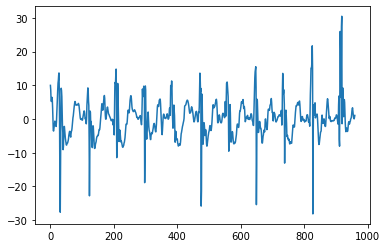

In [ ]:
#P10
T10_acc=all_pre_process_steps('/content/drive/MyDrive/Gab/Participants/P10/exported-X')

T shape: (960, 161, 52)


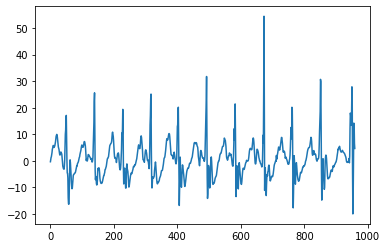

In [ ]:
#P13
T13_acc=all_pre_process_steps('/content/drive/MyDrive/Gab/Participants/P13/exported-X')

T shape: (960, 127, 52)


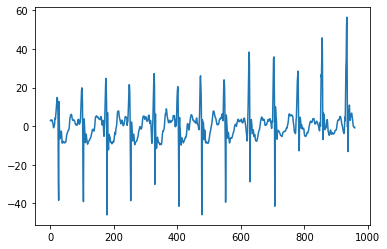

In [ ]:
#P02
T2_acc=all_pre_process_steps('/content/drive/MyDrive/Gab/Participants/P02/exported-X')

In [ ]:
f = open('/content/drive/MyDrive/Gab/Variables_saved/T13_acc.pickle', 'wb')
pickle.dump(T13_acc, f)
f.close()

In [ ]:
T13_acc

Save output from all pre-process function

In [ ]:
#save
# T3_acc=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T3_acc.pickle',T3_acc)
# T4_acc=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T4_acc.pickle',T4_acc)
# T5_acc=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T5_acc.pickle',T5_acc)
# T7_acc=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T7_acc.pickle',T7_acc)
# T8_acc=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T8_acc.pickle',T8_acc)
# T9_acc=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T9_acc.pickle',T9_acc)
# T10_acc=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T10_acc.pickle',T10_acc)
# T13_acc=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T13_acc.pickle',T13_acc)
# T2_acc=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T2_acc.pickle',T2_acc)

Open tensors

In [ ]:
T3_acc= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T3_acc.pickle')
T4_acc= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T4_acc.pickle')
T5_acc= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T5_acc.pickle')
T7_acc= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T7_acc.pickle')
T8_acc= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T8_acc.pickle')
T9_acc= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T9_acc.pickle')
T2_acc= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T2_acc.pickle')
T10_acc= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T10_acc.pickle')
T13_acc= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T13_acc.pickle')

In [ ]:
T_acc_train = tf.concat([T3_acc,T4_acc,T5_acc,T7_acc,T10_acc,T2_acc], axis=1)
print("Tensor_all train shape:", T_acc_train.shape)

T_acc_valid = tf.concat([T8_acc,T9_acc, T13_acc], axis=1)
print("Tensor_all valid shape:", T_acc_valid.shape)

Tensor_all train shape: (960, 898, 52)
Tensor_all valid shape: (960, 480, 52)


Finale reshaping (if sepearating train and validation data participant wise)

In [ ]:
#-----------------shuffle-already removed the frame column in stand function-----------------
T_train_shuffle=tf_shuffle_axis(T_acc_train[:,:,0:52], axis=1, name=None) 
T_valid_shuffle=tf_shuffle_axis(T_acc_valid[:,:,0:52], axis=1, name=None)#validation set

#-----------------data-----------------
  #train
X_train= (T_train_shuffle[:,:,0:51]).numpy() #which columns 
X_reshape_train = X_train.reshape((T_train_shuffle.shape[1],960, 51)) #reshape into (#trial, frames, #channels)

  #test/validation 
X_test=T_valid_shuffle[:,:,0:51].numpy() 
X_reshape_test = X_test.reshape((T_valid_shuffle.shape[1],960, 51)) 

#-----------------label-----------------
  #train
y_train=T_train_shuffle[:,:,51].numpy() 
label_train= y_train[0]
  #test
y_test=T_valid_shuffle[:,:,51].numpy() 
label_test=y_test[0]

#print
print("Data shape train:",X_reshape_train.shape,"Data shape test:",X_reshape_test.shape,"Label shape train:",label_train.shape,"Label shape test:",label_test.shape)

Data shape train: (898, 960, 51) Data shape test: (480, 960, 51) Label shape train: (898,) Label shape test: (480,)


In [ ]:
y_train=T_train_shuffle[:,:,51].numpy() 
label_train= y_train[0]
label_train

#CNN

In [ ]:
model=make_model_1D(X_reshape_train.shape[1:],100,100,100,16,2,SGD(lr=0.001))
history= model.fit(X_reshape_train,label_train, epochs=10, batch_size=100,validation_data=(X_reshape_test,label_test))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
9/9 [==============================] - 28s 3s/step - loss: 0.9960 - accuracy: 0.5145 - val_loss: 0.9888 - val_accuracy: 0.5021
Epoch 2/10
9/9 [==============================] - 26s 3s/step - loss: 0.9990 - accuracy: 0.5156 - val_loss: 0.9794 - val_accuracy: 0.4896
Epoch 3/10
9/9 [==============================] - 27s 3s/step - loss: 0.9768 - accuracy: 0.5011 - val_loss: 0.9861 - val_accuracy: 0.5000
Epoch 4/10
9/9 [==============================] - 26s 3s/step - loss: 0.9813 - accuracy: 0.5256 - val_loss: 0.9720 - val_accuracy: 0.4833
Epoch 5/10
9/9 [==============================] - 26s 3s/step - loss: 0.9687 - accuracy: 0.5178 - val_loss: 0.9697 - val_accuracy: 0.5000
Epoch 6/10
9/9 [==============================] - 27s 3s/step - loss: 0.9553 - accuracy: 0.5523 - val_loss: 0.9698 - val_accuracy: 0.5000
Epoch 7/10
9/9 [==============================] - 29s 3s/step - loss: 0.9668 - accuracy: 0.5256 - val_loss: 0.9732 - val_accuracy: 0.4958
Epoch 8/10
9/9 [==================

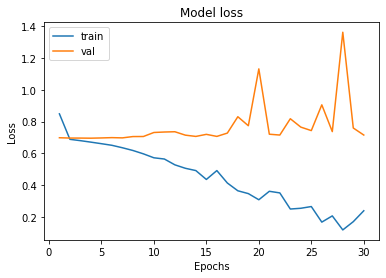

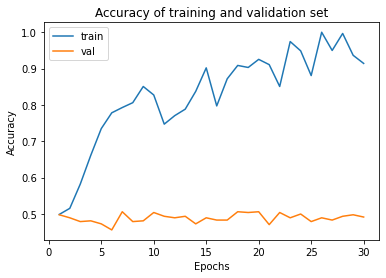

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()